# Function Renaming
## Dataset preparation

This notebook shows how function graphs extracted from a compiled code in assembly language, are imported into Networkx and PyTorch Geometric for later processing.

The code in assembler is processed by a disassembler program (IDA pro in that case), where a plugin creates a graph for each function. The graph consists in 2 txt files containing the information about nodes, edges and attributes.

The goal of this task is to train a model that is able to classify a function in assembler language into several general purpose categories, for example networking, cryptography, control-loop, disk-read-write, computation.

**Topics to take care of:**
- multi-label+multi-class vs only multi-class
- dataset gathering sources:
    - libc
    - linux source code
    - cryptographic libraries
    - opensource web servers source code
    - reversed malware
    - packers/crypters
    - github search for some crypto/network libraries usage and export just the function using it(or 2-3 upper layers)
- we don't need opensource, just compiled code..
- source code could also be used...
- crypto libraries vs code that uses them
- polymorphism applied to do data augmentation

**Notebook index**:
- importing the graph into Nx and drawing it
- importing the graph into PyTorch geometric
- importing several graphs and training a toy model
    

## Original data

The original data consists of disassembly listings of code in assembler. The focus is on functions/subroutines, for each of them a plugin generates 2 txt files containing the information to generate the graph.

The assembler code listing:
![disassembler listing](./img/assembler01.png)


The assembler code in a block view:
![disassembler code blocks view](./img/assembler02.png)

Finally the plugin code is shown below:

In [88]:
from idaapi import *
import os
import datetime

class codeNode():
	def __init__(self, memaddr, type, content, fd_nodes=None, fd_edges=None):
		self.memaddr = memaddr
		self.type = type 
		self.content = content
		self.fd_nodes = fd_nodes
		self.fd_edges = fd_edges
	
	def saveNode(self):
		self.fd_nodes.write("%s {'type': '%s', 'content': '%s'}\n" % (self.memaddr, self.type, self.content))
		
	def saveEdge(self, destination):
		self.fd_edges.write("%s %s {'type': '%s' }\n" % (self.memaddr, destination.memaddr, destination.type))

def initializeFolder():
	prefix = "C:\labs\IDA_pro_book\\" 
	prefix = "H:\IDA_pro_book\\"
	try:
		thedate = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S') 
		folder_name  = AskStr(prefix + "newprogram_"+thedate , "Folder to save files to?")
		# create folder
		os.mkdir(folder_name)
		return folder_name
	except:
		Message(" Error initializing folder!")
		return False

def initializeFiles(folder_name, func):
	try:
		func = get_func(GetFunctionAttr(f, FUNCATTR_START))
		fname = Name(func.startEA)
		
		# initialize files 
		fd_nodes = open(folder_name + "/"+fname+"_nodes.txt", "w")
		fd_edges = open(folder_name + "/"+fname+"_edges.txt", "w")

		return fd_nodes, fd_edges
		
	except:
		Message(" Error initializing files at %s" % folder_name)
		return None, None
		

def instrToStr(instr):
	"""
		Receives a memaddr corresponding to an instruction
		It decodes the instruction and returns its mnemonic
	"""
	instr = DecodeInstruction(instr)
	if instr is not None:
		return instr.get_canon_mnem()
	else:
		return None
			
def processXrefFrom(f, xref, i, fd_nodes, fd_edges):
	# save the caddr as a node (duplicates can exist)
	xref_node = codeNode(str(xref.to), 
						  type="instr", 
						  content=instrToStr(xref.to),
						  fd_nodes = fd_nodes,
						  fd_edges = fd_edges)
	
	if xref.type == fl_CF or xref.type == fl_JF :
		# jump or call far
		xref_node.type = "func"
		xref_node.content = Name(xref.to)
	elif xref.type == fl_CN or xref.type == fl_JN or xref.type == fl_F:
		# jump/call near or ordinary flow
		# compute if it comes from outside the function
		# if it does -> change type to func
		# otherwise do nothing 
	
		# HOW TO COMPUTE: initial func instruction?
		func_start = get_func(GetFunctionAttr(f, FUNCATTR_START))
		
		# HOW TO COMPUTE: last func instruction?
		func_end = get_func(GetFunctionAttr(f, FUNCATTR_END))
		
		# comparison
		inside = xref.to >= func_start and xref.to <= func_end
		
		# decision making
		if inside:
			pass # do nothing
		else:
			xref_node.type = "func"
			xref_node.content = Name(xref.to)

	xref_node.saveNode()
	return xref_node
			
def processOperand(f, op,i, fd_nodes, fd_edges):
	"""
	o_void = 0
 	o_reg = 1
 	o_mem = 2
 	o_phrase = 3
 	o_displ = 4
 	o_imm = 5
 	o_far = 6
 	o_near = 7
 	o_idpspec0 = 8
 	o_idpspec1 = 9
 	o_idpspec2 = 10
 	o_idpspec3 = 11
 	o_idpspec4 = 12
 	o_idpspec5 = 13
	
	"""

	operand_node = codeNode(str(op.addr), 
						  type="data", 
						  content="",
						  fd_nodes = fd_nodes,
						  fd_edges = fd_edges)
						  
	#if op.type in [o_displ, o_phrase]:
	if op.type == o_void:
		return None
	elif op.type == o_displ:		
		# mem ref[BaseReg + index Reg + displ] 
		# mem ref[BaseReg + index Reg] 
		
		#f7maddr.write("%d\n" % (effectivemaddr))
		#f6datamaddr.write("%d,%s,%d\n" % (ea,theinstruction,effectivemaddr))
		
		# alternatively save as an immediate displ or base reg?
		#pass
		operand_node.type="displacement"
		operand_node.content=str(op.value)
	elif op.type == o_mem:
		operand_node.type="memory"
		operand_node.content=str(op.value)
	elif op.type == o_imm:
		operand_node.type="immediate"
		operand_node.content=str(op.value)
	elif op.type == o_reg:
		operand_node.type="register"
		operand_node.content=str(op.reg)
	elif op.type == o_phrase:
		operand_node.type="phrase"
		operand_node.content=str(op.phrase)
	else:
		operand_node.type="unkown"
		operand_node.content=str(op.value)
	
	operand_node.saveNode()
	return operand_node
		
	
def writeGraph(f,  fd_nodes, fd_edges):
	"""
	    This functions writes nodes and edges with the following format
	    Networkx format:
		- edge list: 1 2 ('weight':7, 'color': green, ...)
			- direct import into Networkx
		- node features file:  node id { 'feat1_name': feat1_val, ...}
			- manually add those features into the nodes once imported from edge_list
	
	"""
	func = get_func(GetFunctionAttr(f, FUNCATTR_START))
	if not func is None:
		fname = Name(func.startEA)
		items = FuncItems(func.startEA)	
		
		for i in items:
			# prepare components of each node and edge list entry
			
			# save the origin caddr as a node (the instruction node)
			instr_node = codeNode(str(i), 
								  type="instr", 
								  content=instrToStr(i),
								  fd_nodes = fd_nodes,
								  fd_edges = fd_edges)
			
			
			# save instr. operands as nodes and save edges too 
			instr = DecodeInstruction(i)
			operands = [instr_node.content]
			for op in instr.Operands:
				operand_node = processOperand(f, op,i, fd_nodes, fd_edges)
				if operand_node is not None:
					instr_node.saveEdge(operand_node)
					operands.append(operand_node.content)
			
			instr_node.content = " ".join(operands)
			instr_node.saveNode()
				
			# save xrefs From i
			for xref in XrefsFrom(i,0):
				xref_node = processXrefFrom(f, xref,i, fd_nodes, fd_edges)
				instr_node.saveEdge(xref_node)
		
			
			
folder_name = initializeFolder()
if not folder_name:
	Message("Error creating folder!")
	exit()

funcs = Functions()
for f in funcs:
	fd_nodes, fd_edges = initializeFiles(folder_name,f)
	writeGraph(f, fd_nodes, fd_edges)		
	fd_edges.close()
	fd_nodes.close()
			

			

				
# #      Flow types (combine with XREF_USER!):
# fl_CF   = 16              # Call Far
# fl_CN   = 17              # Call Near
# fl_JF   = 18              # jumpto Far
# fl_JN   = 19              # jumpto Near
# fl_F    = 21              # Ordinary flow

# XREF_USER = 32            # All user-specified xref types
                          # # must be combined with this bit
						  					  
# # Data reference types (combine with XREF_USER!):
# dr_O    = ida_xref.dr_O  # Offset
# dr_W    = ida_xref.dr_W  # Write
# dr_R    = ida_xref.dr_R  # Read
# dr_T    = ida_xref.dr_T  # Text (names in manual operands)
# dr_I    = ida_xref.dr_I  # Informational

# add_dref = ida_xref.add_dref
# del_dref = ida_xref.del_dref
# get_first_dref_from = ida_xref.get_first_dref_from
# get_next_dref_from = ida_xref.get_next_dref_from
# get_first_dref_to = ida_xref.get_first_dref_to
# get_next_dref_to = ida_xref.get_next_dref_to

ModuleNotFoundError: No module named 'idaapi'

## Networkx Visualization

We import the graphs into Networkx to visualize them and to verify the correctness

In [89]:
# import one function graph to nx and plot it
import networkx as nx
import json
import matplotlib.pyplot as plt

folder ='./plugin/newprogram_2019-04-04_13-22-02/'
filename = 'sub_DB2A93_edges.txt'
#filename = 'WINHTTP_452F00_edges.txt'


# read nodes, edges and  edge attributes
g = nx.read_edgelist(folder+filename)
# read node attributes
with open(folder+filename.replace('edges','nodes'),'r') as f:
    for line in f.readlines():
        tokens = line.split("{")
        nodeid = tokens[0][:-1]
        #print(nodeid)
        #print(tokens[1])
        attr_dict = json.loads('{ '+tokens[1].replace('\'','"'))
        #print(nodeid)
        #print(attr_dict)
        for k,v in attr_dict.items():
            g.node[nodeid][k] = v

In [90]:
i=0
for n1, n2, attr in g.edges(data=True): # unpacking
    print(n1, n2, attr) 
    i+=1
    if i>3: break


14363283 0 {'type': 'register'}
14363283 14363284 {'type': 'func'}
0 14363284 {'type': 'register'}
0 14363286 {'type': 'immediate'}


In [91]:
i=0
for n in g.nodes(data=True):
    print(n)
    i+=1
    if i>10: break

('14363283', {'type': 'instr', 'content': 'push 5'})
('0', {'type': 'register', 'content': '6'})
('14363284', {'type': 'instr', 'content': 'mov 5 4'})
('14363286', {'type': 'instr', 'content': 'sub 4 16'})
('14363289', {'type': 'instr', 'content': 'mov 0 0'})
('14386800', {'type': 'instr', 'content': 'dec'})
('14363294', {'type': 'instr', 'content': 'test 0 0'})
('14363296', {'type': 'instr', 'content': 'jz 0'})
('14363305', {'type': 'instr', 'content': 'push 6'})
('14363298', {'type': 'instr', 'content': 'cmp 0 3141592654'})
('14363303', {'type': 'instr', 'content': 'jnz 0'})


/home/pau/.pyenv/versions/3.6.7/envs/gnn-pytorch/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


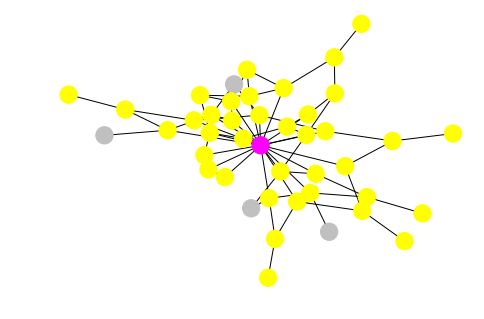

In [92]:
# color plot
attrs={}
palette = ['yellow', 'cyan','orange','red','magenta', 'silver','grey','blue','green',   'pink','black',]
types =['instr','func','immediate','memory','register',
        'displacement','phrase','unknown']

for node in g.nodes():
    if 'type' in g.node[node].keys():
        i = types.index(g.node[node]['type'])
    else:
        i=len(types)+1
    attrs[node]={'color':palette[ i % len(palette)]}

nx.set_node_attributes(g, attrs)
colors = nx.get_node_attributes(g, 'color')
nx.draw(g, node_color=colors.values())
plt.draw()

In [115]:
import networkx as nx
import json
import matplotlib.pyplot as plt

def readGraph(folder, filename):
    # read nodes, edges and  edge attributes
    g = nx.read_edgelist(folder+filename)
    # read node attributes
    with open(folder+filename.replace('edges','nodes'),'r') as f:
        for line in f.readlines():
            tokens = line.split("{")
            nodeid = tokens[0][:-1]
            #print(nodeid)
            #print(tokens[1])
            attr_dict = json.loads('{ '+tokens[1].replace('\'','"'))
            #print(nodeid)
            #print(attr_dict)
            for k,v in attr_dict.items():
                g.node[nodeid][k] = v
                
    return g

def prepareLabelDict(g, attr):
    label_dict = {}
    for node in g.nodes():
        if attr == 'all':
            label_dict[node]=node + " " + \
                             g.node[node]['content']
        else:
            label_dict[node]=g.node[node][attr]
    return label_dict

def plotGraph(g, label=None):
    
    # color plot
    attrs={}
    palette = ['cyan', 'orange','yellow',
               'red','blue', 'grey',
               'magenta','green','black',   
               'pink',]
    types =['instr','register','immediate','memory',
        'displacement','phrase','func','unknown']
    
    for node in g.nodes():
        if 'type' in g.node[node].keys():
            i = types.index(g.node[node]['type'])
        else:
            i=len(palette)-1
        attrs[node]={'color':palette[ i % len(palette)]}

    nx.set_node_attributes(g, attrs)
    colors = nx.get_node_attributes(g, 'color')
    if label:
        
        label_dict= prepareLabelDict(g,attr=label)
        nx.draw(g, 
            node_color=colors.values(),
            labels=label_dict,
            with_labels = True  )
    #nx.draw_circular(g, node_color=colors.values())
    #plt.draw()
    else:
        nx.draw(g, 
            node_color=colors.values())
    
def plotGraphFunction(folder, filename, label=None):
    g = readGraph(folder, filename)
    plotGraph(g,label)
    

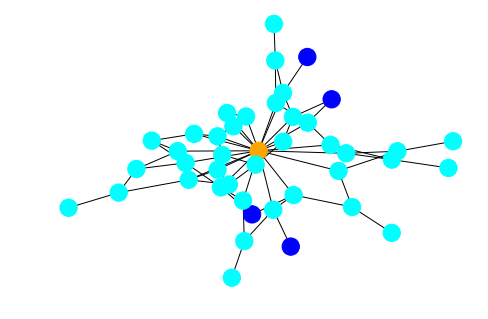

In [94]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB2A93_edges.txt')


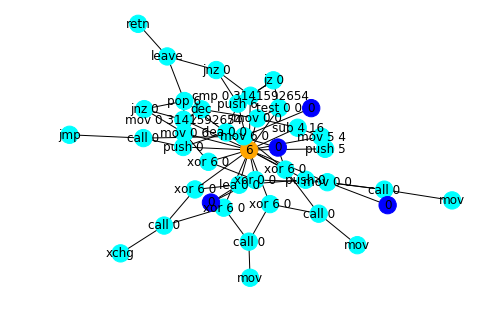

In [95]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB2A93_edges.txt',
                  label='content')


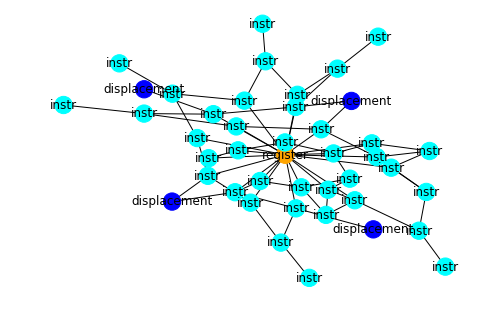

In [96]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB2A93_edges.txt',
                  label='type')


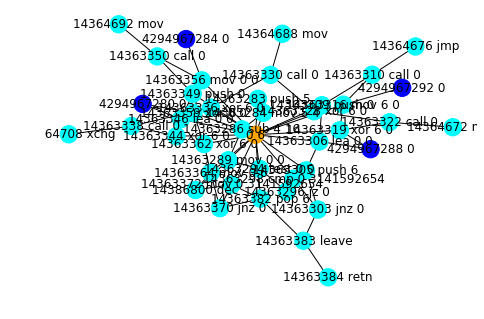

In [97]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB2A93_edges.txt',
                  label='all')

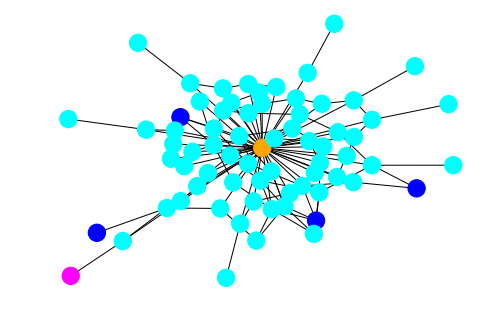

In [98]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB1B40_edges.txt')

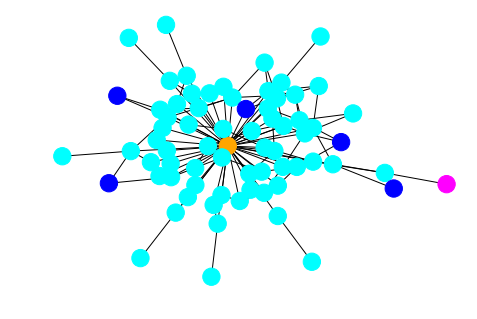

In [99]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-04_13-22-02/',
                  filename = 'sub_DB1BE0_edges.txt')

## PyTorch Geometric import

The graphs are imported into PyTorch Geometric to verify correctness and feasability. At the end a toy model is trained on some of the graphs to distinguish between network usage and no networks usage

In [125]:
import importlib
import torch
from torch_geometric.data import DataLoader
import networkx as nx
from torch_geometric.data import Data
import time
import pickle
from torch_geometric.data import InMemoryDataset
import numpy as np
import traceback
import random
from numpy.random import choice
import pandas as pd
import os


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


def createDataset(x, edge_index):
    """
        Creates a PyTorch Geometric Dataset
        from a torch tensor (node features) x
        and an edge_index (adjacency list in the form
        [[n1, n1, n1, n2, n2, n3], [n1, n3, n2, n3, n1, n1]]
        for the edges (n1,n1), (n1,n3), (n1,n2), (n2, n3), (n2, n1)
        and (n3, n1)
    """
    return Data(x=x, edge_index=edge_index)
    

def createDatasetFromNX(g, xlen, undirected=True):
    """
        Creates a PyTorch Geometric dataset
        from a NetworkX graph
        
        node features -> to one-hot-encoding
            - type (string)
            - content
                - reg number string -> to int
                - displacement number string -> to int?
                - memory/ other string -> to what?
                
    """
    # get edge list
    edges = g.edges
    edge_list_1 = []
    edge_list_2 = []
    for e in edges:
        # node id must be an int
        edge_list_1.append(int(e[0])) 
        edge_list_2.append(int(e[1]))
        if undirected:
            edge_list_1.append(int(e[1])) 
            edge_list_2.append(int(e[0]))
            
        
    edge_index = torch.tensor([ edge_list_1,
                                edge_list_2], dtype=torch.long)
    
    # create single 1 feature for each node
    n = xlen
    x = [[1.0] for i in range(n)]
    x = torch.tensor(x, dtype=torch.float)
    
    return createDataset(x, edge_index)
                         
def createDatasetFromNXwithTarget(g,y,xlen, undirected=True):
    """
        Creates a PyTorch Geometric dataset
        from a NetworkX graph
        with node features (called target and represented by y )
        
        PENDING:
            - appepnd many Datas to the dataset
    """
    dataset =  createDatasetFromNX(g,xlen, undirected)
    y = torch.FloatTensor(y)
    dataset.y = y 
    return dataset


def createPyGDataset(folder):
    # read folder
    # and create g for each pair of files
    # transform this g into a Data() and put into a list
    g_list = []
    #g_class = []
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in files:
            # and create g for each pair of files
            filename = os.path.join(root, name)
            if filename.find('_edges') > -1:
                
                # extract class from name? 
                y = 0
                if filename.lower().find('http')>-1 or \
                   filename.lower().find('network')>-1 or \
                   filename.lower().find('send')>-1:
                    #g_class.append(1)
                    y = 1
                #else:
                #    g_class.append(0)
                
                # generate the nx and PyG graph
                try:
                    g = readGraph('',filename)
                    xlen = len(g.nodes())
                    G = createDatasetFromNXwithTarget(g,y,xlen,undirected=True)
                    g_list.append(G)
                except:
                    print(" Problem with "+filename)
                    
            
    
    # create a dataset
    data, slices = InMemoryDataset.collate(None, g_list) # hacky way
    torch.save((data, slices), 'dataset.pt')


In [126]:
createPyGDataset('./plugin/malw01_2019-04-04_17-52-13/')

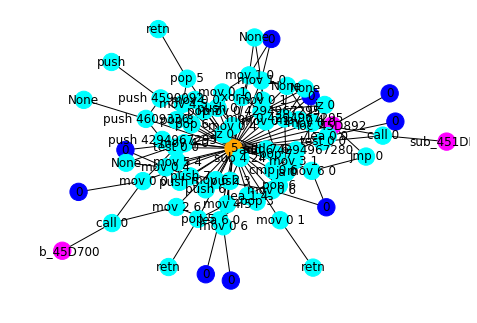

In [117]:
plotGraphFunction(folder ='./plugin/malw01_2019-04-04_17-44-51/',
                  filename = 'sub_45D850_edges.txt',
                  label='content')